### ***Dataset*** 

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
df = pd.read_csv('intern_task.csv', header=0)
df.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


### ***Checking Dataset***

In [103]:
from scipy.stats import zscore

print('Number of missing values int the data:', df.isna().sum().sum())
print('Number of outliers in the data:', df[(np.abs(zscore(df)) < 3).all(axis=1)].shape[0])
print('Number of non-numeric features:', sum(df.drop(columns=['rank', 'query_id']).select_dtypes(exclude=['number'])))
print(f'Number of feature pairs with Pearson correlation > 0.7 out of {int(df.shape[1] ** 2 / 2)}:',
      int((df.shape[1] ** 2 - df.corr()[lambda x: x > 0.7].isna().sum().sum() - df.shape[1]) / 2))

Number of missing values int the data: 0
Number of outliers in the data: 0
Number of non-numeric features: 0
Number of feature pairs with Pearson correlation > 0.7 out of 10658: 392


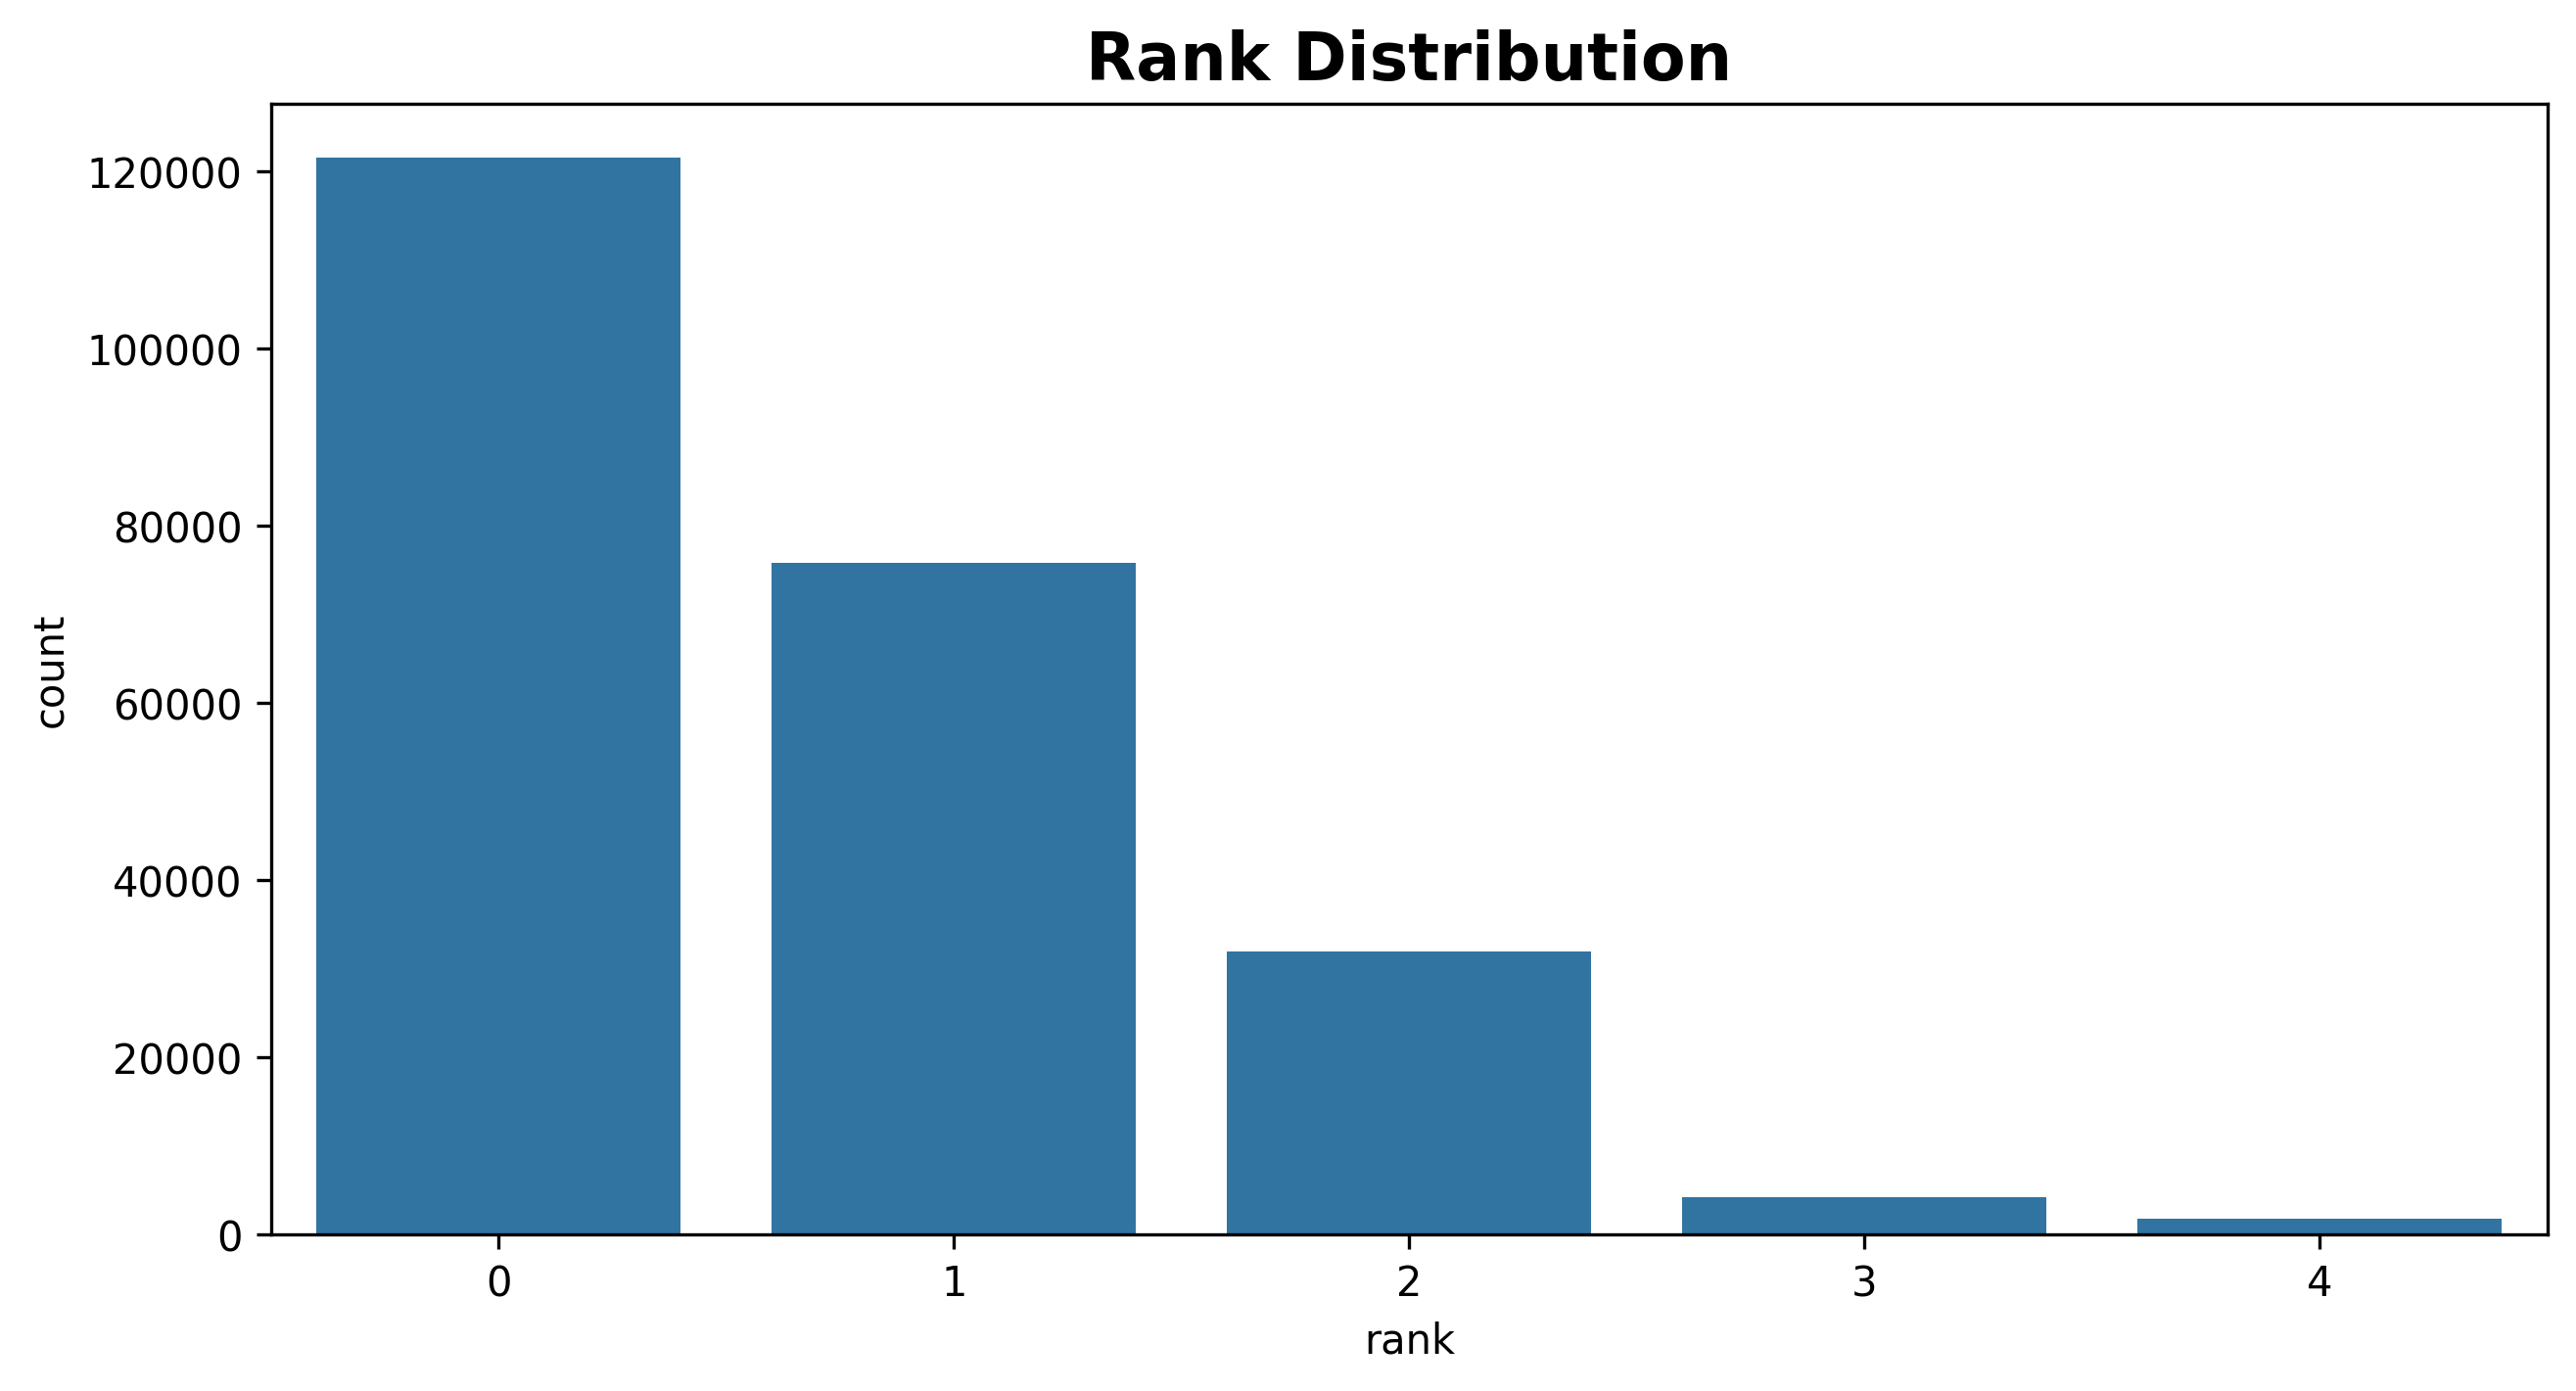

In [104]:
plt.figure(figsize=(10, 5), dpi=300)

ax = sns.barplot(df['rank'].value_counts())

plt.title('Rank Distribution', weight='bold').set_fontsize(16)
plt.show();

### ***Preprocessing***

In [105]:
X = df.drop(columns=['rank'])
y = df['rank']

In [106]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for i, j in splitter.split(X, y, groups=X["query_id"]):
    X_train, X_test = X.iloc[i], X.iloc[j]
    y_train, y_test = y.iloc[i], y.iloc[j]

### ***Training***

*Решить задачу вполне можно несложным градиентным бустингом над решающими деревьями небольшой глубины и размера ансамбля. Из-за малых вычислительных мощностей и небольшого количества свободного времени полноценный GridSpecCV не реализовал. Его код закоментил ниже. Гиперпараметры модели подобрал вручную за ~10 обучений.*

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
model = xgb.XGBClassifier(objective='rank:pairwise', eval_metric='ncdg@5')
param_grid = {"learning_rate": [0.01, 0.05, 0.1],
              "n_estimators": [100, 200, 300],
              "max_depth": [3, 4, 5],  
              "gamma": [0.1, 0.2, 0.3],
              "n_estimators": [100, 200, 300],
              "grow_policy": ["lossguide", "depth-wise"]
              }
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

In [109]:
import xgboost as xgb
model = xgb.XGBClassifier(objective='rank:pairwise',
                          booster='gbtree',
                          eval_metric='ndcg@5',
                          learning_rate=0.2, 
                          max_depth=3, 
                          grow_policy="lossguide"
                          )

In [111]:
model.fit(X_train, y_train);

In [112]:
y_pred = model.predict(X_test)

In [113]:
model.score(X_test, y_test)

0.5734931565076936

### ***Metrics***

##### Normalized Discounted Cumulative Gain at 5 (nDCG@5)

In [114]:
from sklearn.metrics import ndcg_score

y_p = model.predict(X_train)
y_sc = y_p.reshape((-1, y_p.shape[0]))
y_tr = y_train.to_numpy().reshape((-1, y_train.shape[0]))
print('ndcg@5 on train =', ndcg_score(y_tr, y_sc, k=5))

y_score = y_pred.reshape((-1, y_pred.shape[0]))
y_true = y_test.to_numpy().reshape((-1, y_test.shape[0]))
print('ndcg@5 on test =', ndcg_score(y_true, y_score, k=5))

ndcg@5 on train = 0.8213028169014085
ndcg@5 on test = 0.7763157894736842


переобучения не наблюдаем, значение ndcg@5 близко к 1 - значит всё хорошо.